# Importing Libraries

In [ ]:
from math import pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score
import joblib

#Data loading

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Mehtab FYP/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Mehtab FYP/test.csv')

print("Train shape", train_df.shape)
print("Test shape", test_df.shape)


Train shape (1460, 81)
Test shape (1459, 80)


In [ ]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA

In [ ]:
#checking for missing values
missing = train_df.isnull().sum()
missing = missing[missing>0].sort_values(ascending=False)
print("Missing values: \n", missing.head(10))

Missing values: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64


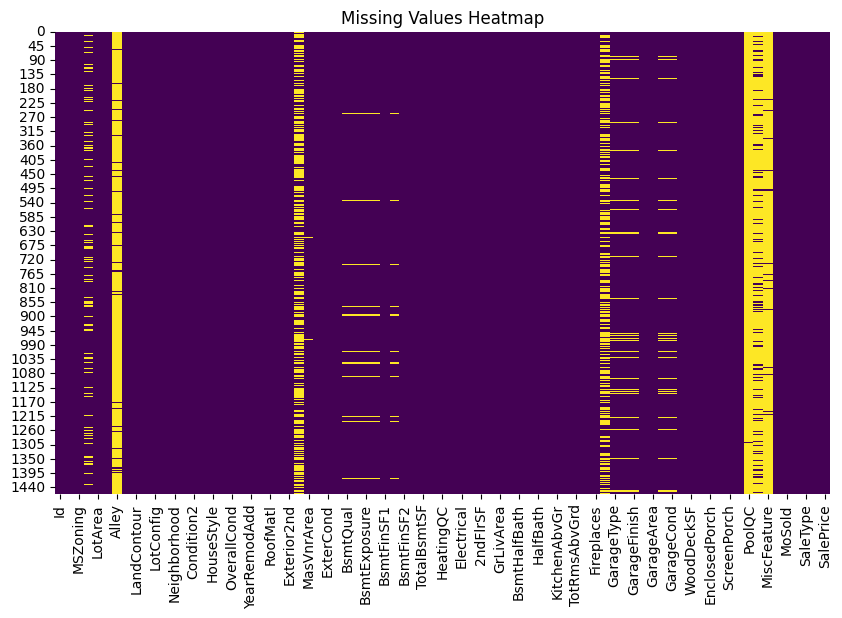

In [ ]:
#Missing data heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

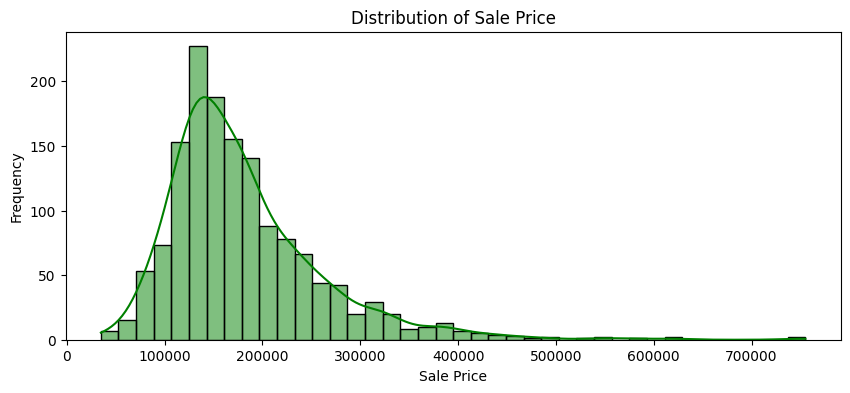

In [ ]:
#Target value distribution
plt.figure(figsize=(10, 4))
sns.histplot(train_df['SalePrice'], kde=True, bins=40, color='green')
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.show()

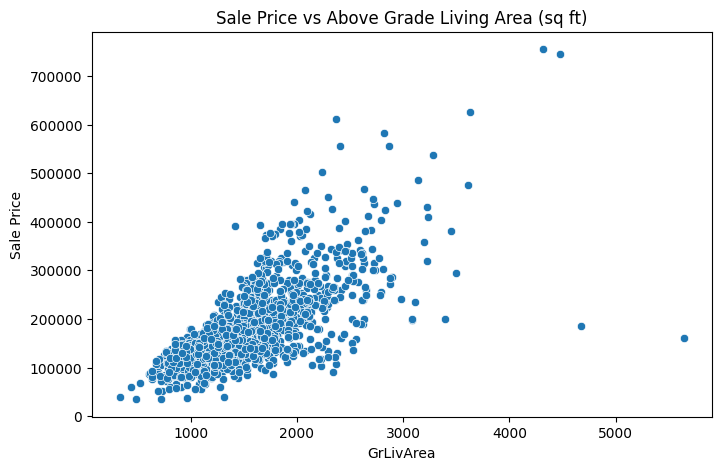

In [ ]:

# 4. SalePrice vs GrLivArea (Scatter Plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title("Sale Price vs Above Grade Living Area (sq ft)")
plt.xlabel("GrLivArea")
plt.ylabel("Sale Price")
plt.show()

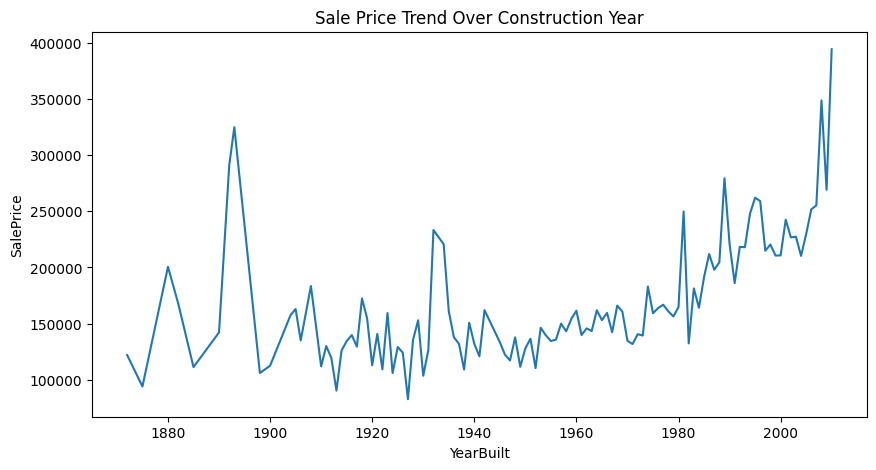

In [ ]:
# 6. SalePrice vs YearBuilt (Trend)
plt.figure(figsize=(10, 5))
sns.lineplot(data=train_df.sort_values("YearBuilt"), x="YearBuilt", y="SalePrice", ci=None)
plt.title("Sale Price Trend Over Construction Year")
plt.show()

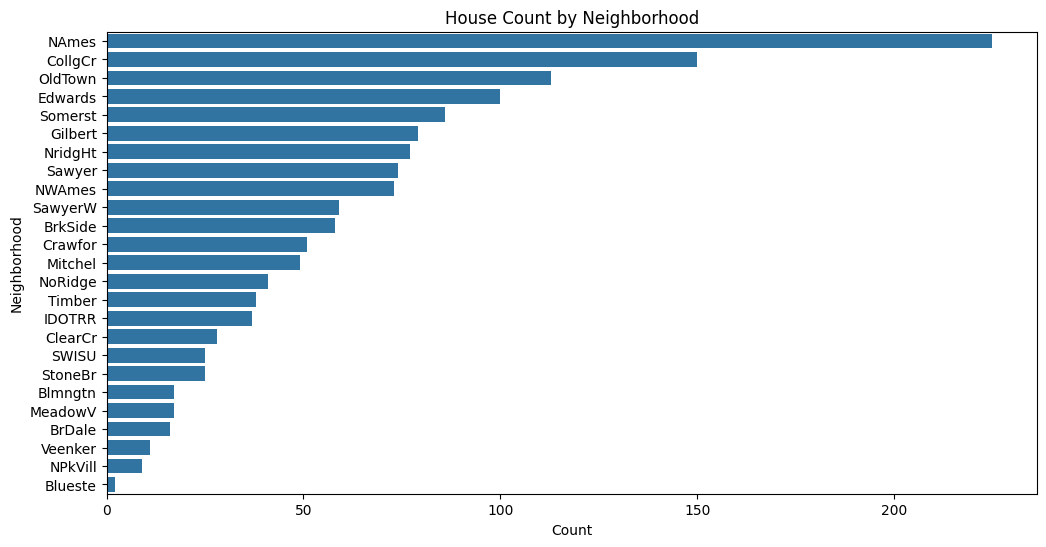

In [ ]:
# 7. Count of Houses by Neighborhood
plt.figure(figsize=(12, 6))
sns.countplot(y="Neighborhood", data=train_df, order=train_df['Neighborhood'].value_counts().index)
plt.title("House Count by Neighborhood")
plt.xlabel("Count")
plt.ylabel("Neighborhood")
plt.show()

In [ ]:
!pip install plotly


In [ ]:
import plotly.express as px

# Interactive 1: Scatter Plot - SalePrice vs GrLivArea
fig = px.scatter(train_df, x='GrLivArea', y='SalePrice', color='OverallQual',
                 title='SalePrice vs GrLivArea (colored by Overall Quality)',
                 hover_data=['Neighborhood', 'YearBuilt'])
fig.show()

In [ ]:
# Create a treemap showing median SalePrice by Neighborhood
neigh_price = train_df.groupby("Neighborhood")["SalePrice"].median().reset_index()
fig = px.treemap(neigh_price, path=["Neighborhood"], values="SalePrice",
                 title="Median Sale Price by Neighborhood (Treemap Style)")
fig.show()


# Data Preprocessing & Feature Engineering

In [ ]:
#Droping outliers
train_df = train_df[train_df['GrLivArea']< 4500]


In [ ]:
# Separate target
y = train_df['SalePrice']
X = train_df.drop(['Id', 'SalePrice'], axis=1)

In [ ]:

# Combine with test data for uniform processing
all_data = pd.concat([X, test_df.drop('Id', axis=1)], axis=0)

In [ ]:
# Numerical and categorical columns
num_features = all_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = all_data.select_dtypes(include=['object']).columns.tolist()


In [ ]:
# Combine with test data for uniform processing
all_data = pd.concat([X, test_df.drop('Id', axis=1)], axis=0)

# Numerical and categorical columns
num_features = all_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = all_data.select_dtypes(include=['object']).columns.tolist()

# Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


# Model Building & Comparison

In [ ]:
# Split back to train
X_processed = preprocessor.fit_transform(all_data)
X_train = X_processed[:len(train_df)]
X_test_final = X_processed[len(train_df):]

In [ ]:
# Train-test split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor



In [ ]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

In [ ]:
# Training & Evaluation
results = []
for name, model in models.items():
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    results.append((name, rmse, r2))
    print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.4f}")

Linear Regression -> RMSE: 25265.60, R2: 0.8844
Random Forest -> RMSE: 24445.57, R2: 0.8918
Gradient Boosting -> RMSE: 21226.80, R2: 0.9184
XGBoost -> RMSE: 23509.45, R2: 0.8999


# Select Best Model & Save

In [ ]:
# Sort and show model results
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2"]).sort_values(by="R2", ascending=False)
print(results_df)


               Model          RMSE        R2
2  Gradient Boosting  21226.799780  0.918429
3            XGBoost  23509.447973  0.899942
1      Random Forest  24445.571386  0.891815
0  Linear Regression  25265.598849  0.884435


In [ ]:

# Save best model
best_model = models[results_df.iloc[0]['Model']]
best_model.fit(X_train, y)
joblib.dump((best_model, preprocessor), "house_price_model.pkl")

print(f"\nSaved best model: {results_df.iloc[0]['Model']}")


Saved best model: Gradient Boosting
